#### 1.0 Importing data and relevant libraies:

In [ ]:
##Pre processing libs:
from warnings import simplefilter
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import random
from keras import utils as np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch


##Modelling & Evaluation libs:
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from google.colab import drive
import torch
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

#Ignorering future warnings
simplefilter(action='ignore', category=FutureWarning)

#Function for downloading data into current session. 
#Go to Kaggle > Account > Get API token, if token not defined.
def getdata(APItoken):
  os.environ['KAGGLE_USERNAME'] = "nikolajtrampedach"
  os.environ['KAGGLE_KEY'] = APItoken
  try:
    !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    !unzip gtsrb-german-traffic-sign.zip
    print('********** Downloading and unzipping completed **********')
  except: 
    print('*********** An error occured while processing ***********')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Downloading data with the Kaggle API token
getdata('***INSERT YOUR OWN APITOKEN***')

#### 2.0 Data Processing


In [ ]:
#Defining lable names:
ClassDict = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
#First, we investigate the average image size prior to resizing the images.
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

print('The average train width of images is: {}'.format(train['Width'].mean()))
print('The average train height of images is: {}\n'.format(train['Height'].mean()))

print('The average test width of images is: {}'.format(test['Width'].mean()))
print('The average test height of images is: {}'.format(test['Height'].mean()))

The average train width of images is: 50.83587951745773
The average train height of images is: 50.328929582493814

The average test width of images is: 50.50775930324624
The average test height of images is: 50.36444972288203


In [ ]:
#Mapping all class instances with the respectfully name in Classdict. 

train["class_nm"] = train["ClassId"].map(ClassDict)
test["class_nm"] = test["ClassId"].map(ClassDict)

Test reference: 1986
Class name: Speed limit (30km/h)



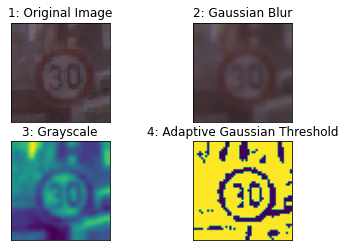

In [ ]:
#plotting a visual example of the four stages in the image processing

random_int = random.randint(1,31367)
step = 1

img_org = image.load_img(train['Path'][random_int],target_size=(49,49,3))
img = image.img_to_array(img_org)
img_blur = cv2.GaussianBlur(img, (49, 49), 1).astype('uint8') 
img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY)
#img_gray2 = cv2.cvtColor(img_gray1, cv2.COLOR_GRAY2RGB) #imshow do not work with RGB2GRAY, so this is only needed to plot grayscale img.
img_thresh_Gaussian = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)

print('Test reference: {}'.format(random_int))
print('Class name: {}\n'.format(train["class_nm"][random_int]))

titles = ['1: Original Image', '2: Gaussian Blur', 
          '3: Grayscale', '4: Adaptive Gaussian Threshold']
image_list = (img_org,img_blur,img_gray,img_thresh_Gaussian)

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(image_list[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [ ]:
#Building training data
data_list = []
for i in tqdm(range(train.shape[0])):
  img_org = image.load_img(train['Path'][i],target_size=(49,49,3)) #Resizing
  img = image.img_to_array(img_org)
  #norm_img = cv.normalize(img,  norm_img, 0, 255, cv.NORM_MINMAX) #Not sure if normalization is useful, hence we blur with GB afterwards
  img_blur = cv2.GaussianBlur(img, (49, 49), 1).astype('uint8') #Adding Gaussian Smoothing function (img size reduced, hence GB only works with odd sizes)
  img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY) #Converting image from RGB to Grayscale
  img_thresh_Gaussian = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C ,cv2.THRESH_BINARY, 11, 2) #Adaptive threshold using 11 nearest pixels
  data_list.append(img_thresh_Gaussian) #Appending each image to data_list
X = np.array(data_list) / 255.00 #Scaling pizels from range(0-255) to range (0.0-1.0)
y = np.array(train['class_nm'])
    
 

100%|██████████| 39209/39209 [00:37<00:00, 1044.29it/s]


In [ ]:
#Building test data
data_list = []
for i in tqdm(range(test.shape[0])):
  img_org = image.load_img(test['Path'][i],target_size=(49,49,3)) #Resizing
  img = image.img_to_array(img_org)
  #norm_img = cv.normalize(img,  norm_img, 0, 255, cv.NORM_MINMAX) #Not sure if normalization is useful, hence we blur with GB afterwards
  img_blur = cv2.GaussianBlur(img, (49, 49), 1).astype('uint8') #Adding Gaussian Smoothing function (img size reduced, hence GB only works with odd sizes)
  img_gray = cv2.cvtColor(img_blur, cv2.COLOR_RGB2GRAY) #Converting image from RGB to Grayscale
  img_thresh_Gaussian = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C ,cv2.THRESH_BINARY, 11, 2) #Adaptive threshold using 11 nearest pixels
  data_list.append(img_thresh_Gaussian) #Appending each image to data_list        
X_test = np.array(data_list) / 255.00 #Scaling pizels from range(0-255) to range (0.0-1.0)
y_test = np.array(test['class_nm'])

100%|██████████| 12630/12630 [00:11<00:00, 1056.35it/s]


In [ ]:
"""In order to have a validation dataset, we split the X and y derived from the train folder in to train and validation
Hence, the image dir folder is ordered, we include shuffle = True in the train_test_split to ensure all classes are represented """

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, shuffle = True, random_state=1)

instances = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]

print('Total instances of data available: {}\n'.format(instances))
print('Shape of X_train: {}  -  {:.1f} pct.'.format(X_train.shape,X_train.shape[0]/instances*100))
print('Shape of X_val:   {}   -  {:.1f} pct.'.format(X_val.shape,X_val.shape[0]/instances*100))
print('Shape of X_test:  {}  -  {:.1f} pct.'.format(X_test.shape,X_test.shape[0]/instances*100))

Total instances of data available: 51839

Shape of X_train: (31367, 49, 49)  -  60.5 pct.
Shape of X_val:   (7842, 49, 49)   -  15.1 pct.
Shape of X_test:  (12630, 49, 49)  -  24.4 pct.


#### 3.0 Data Exploration

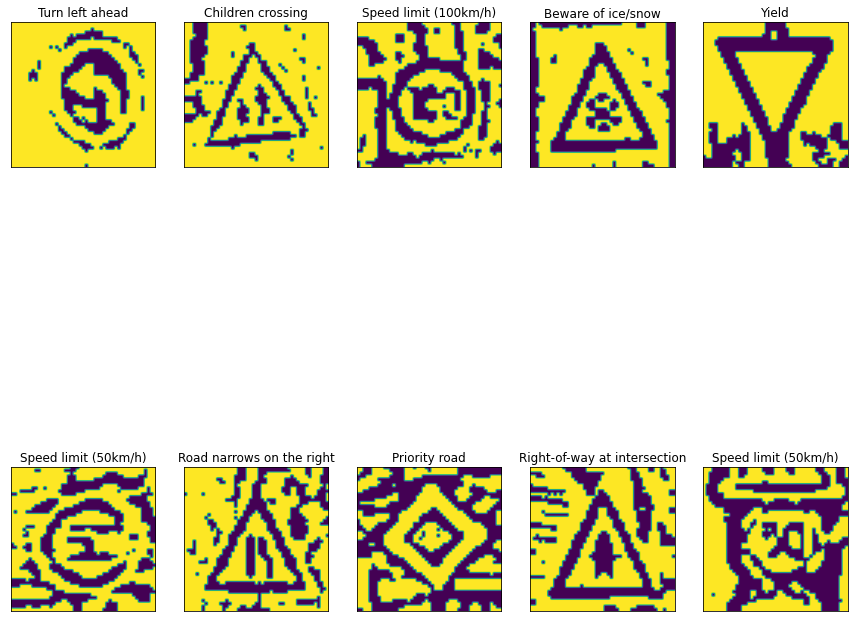

In [ ]:
#Plotting 10 random images
fig, axs = plt.subplots(figsize=(15, 15))
for i in range(0,10):
  random_int = random.randint(1,31367)
  plt.subplot(2,5,i+1),plt.imshow(X_train[random_int])
  plt.title(y_train[random_int])
  plt.xticks([]),plt.yticks([])
plt.show()

(array([1200., 1656., 1584.,  960., 1800., 1680.,  960.,  192., 1608.,
         216., 1128., 1728., 1176.,  192.,  504.,  360., 1776., 1488.,
         480.,  264.,  888., 1056.,  408.,  336.,  336.,  624., 1128.,
         192.,  192.,  336.,  168.,  551.,  288.,  432.,  216.,  312.,
         624., 1152.,  288.,  240.,  168.,  168.,  312.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of

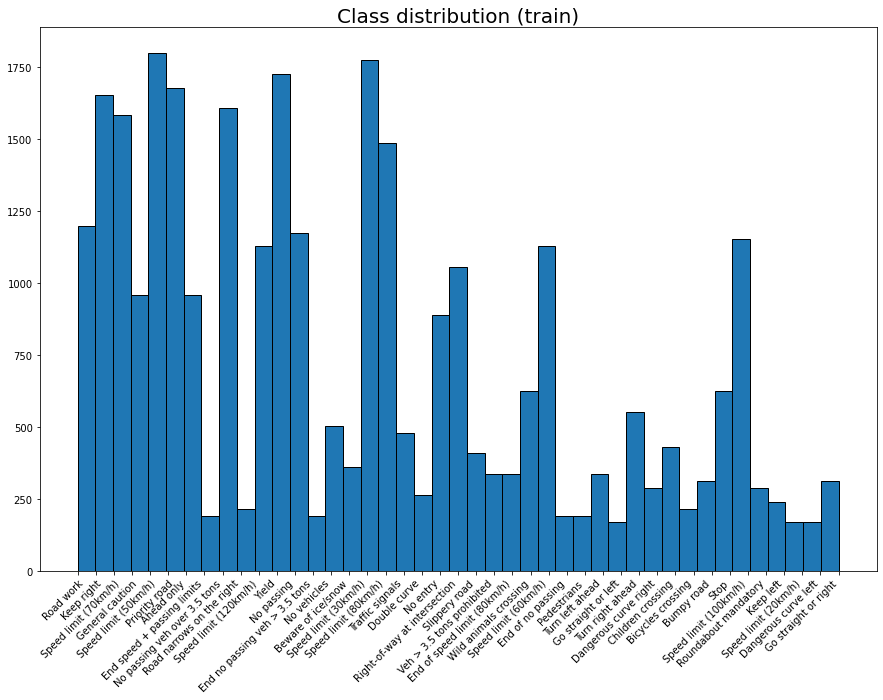

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Class distribution (train)',fontsize=20)
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")

display(plt.hist(y_train,bins=43, histtype='bar', ec='black'))

(array([150., 720., 690., 210., 420., 390., 690., 480., 390., 450., 150.,
        660., 480.,  90.,  90.,  60., 450., 720., 660., 630., 360., 120.,
        750., 450., 150.,  90., 210., 180., 150., 120., 270.,  60.,  90.,
        150., 120.,  90.,  60., 270.,  60.,  60.,  90., 150.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42.]),
 <a list of 42 Patch objects>)

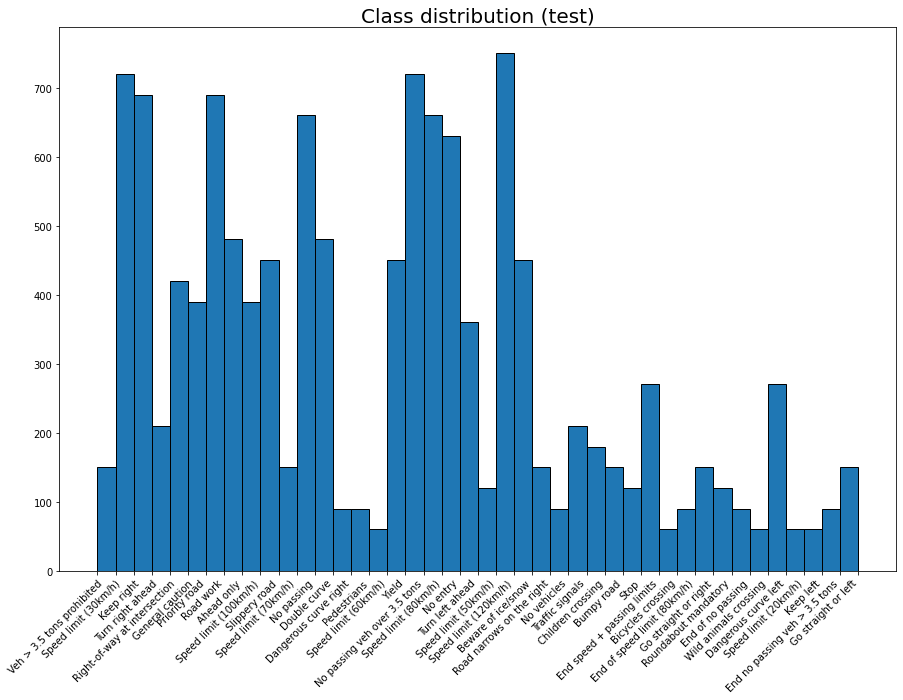

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Class distribution (test)',fontsize=20)
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
display(plt.hist(y_test,bins=42, histtype='bar', ec='black'))

#### 4.0 Modelling

In [ ]:
#Shaping X and Y array to match the requirements of Sklearn (only 2D arrays)
X_train_shaped = X_train.reshape((len(X_train),-1))
X_val_shaped = X_val.reshape((len(X_val),-1))
X_test_shaped = X_test.reshape((len(X_test),-1))

print('Training set - original shape {}, configured shape {}'.format(X_train.shape,X_train_shaped.shape))
print('Validation set - original shape {}, configured shape {}'.format(X_val.shape,X_val_shaped.shape))
print('Testing set - original shape {}, configured shape {}'.format(X_test.shape,X_test_shaped.shape))

Training set - original shape (31367, 49, 49), configured shape (31367, 2401)
Validation set - original shape (7842, 49, 49), configured shape (7842, 2401)
Testing set - original shape (12630, 49, 49), configured shape (12630, 2401)


##### 4.1a Naieve Majority Classifier

In [ ]:
sign_counter = Counter(y_test).most_common(1)[0]
 
print('The most frequent traffic sign is *{}*\nwith {} instances out of {} instances in the total training set.'.format(sign_counter[0],sign_counter[1],X_test_shaped.shape[0]))
print('\nBy using this as a baseline model, we will have an accuracy of: {:.2f}%.'.format(sign_counter[1]/X_test_shaped.shape[0]*100))


The most frequent traffic sign is *Speed limit (50km/h)*
with 750 instances out of 12630 instances in the total training set.

By using this as a baseline model, we will have an accuracy of: 5.94%.


In [ ]:
dummy_clf1 = DummyClassifier(strategy="most_frequent")
dummy_clf1.fit(X_train_shaped, y_train)

predDummy1_test = dummy_clf1.predict(X_test_shaped)

print("Test Score:: {:.2f}%".format(dummy_clf1.score(X_test_shaped, y_test)*100))

Test Score:: 5.94%


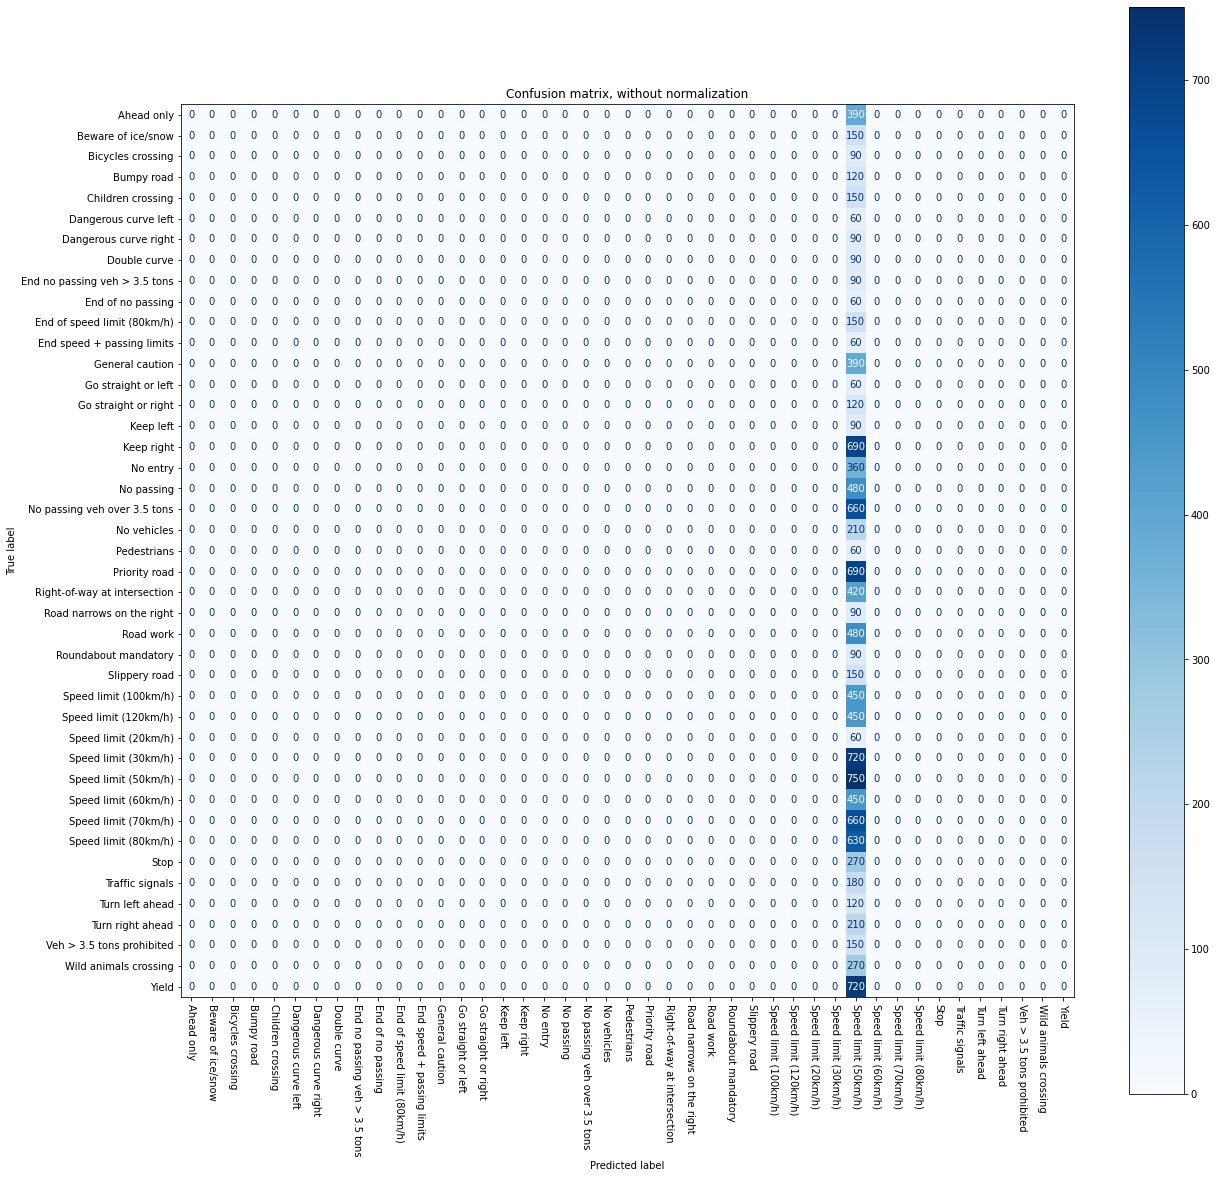

In [ ]:
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(y_test, predDummy1_test)
#print("Confusion matrix:\n{}".format(confusion_matrix(y_test, predDummy1_test)))


titles_options = [("Confusion matrix, without normalization", None)
                  ]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dummy_clf1, X_test_shaped, y_test,
                                 cmap=plt.cm.Blues,
                                 values_format='d'
                                 )
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches(20,20)
    plt.xticks(rotation=270)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

##### 4.1b Stratified Dummy Classifier baseline

In [ ]:
### Model 2 - Random predictions based on class distribution

dummy_clf2 = DummyClassifier(strategy="stratified")
dummy_clf2.fit(X_train_shaped, y_train)

predDummy2_test = dummy_clf2.predict(X_test_shaped)

print("Test Score:: {:.2f}%".format(dummy_clf2.score(X_test_shaped, y_test)*100))



Test Score:: 3.90%


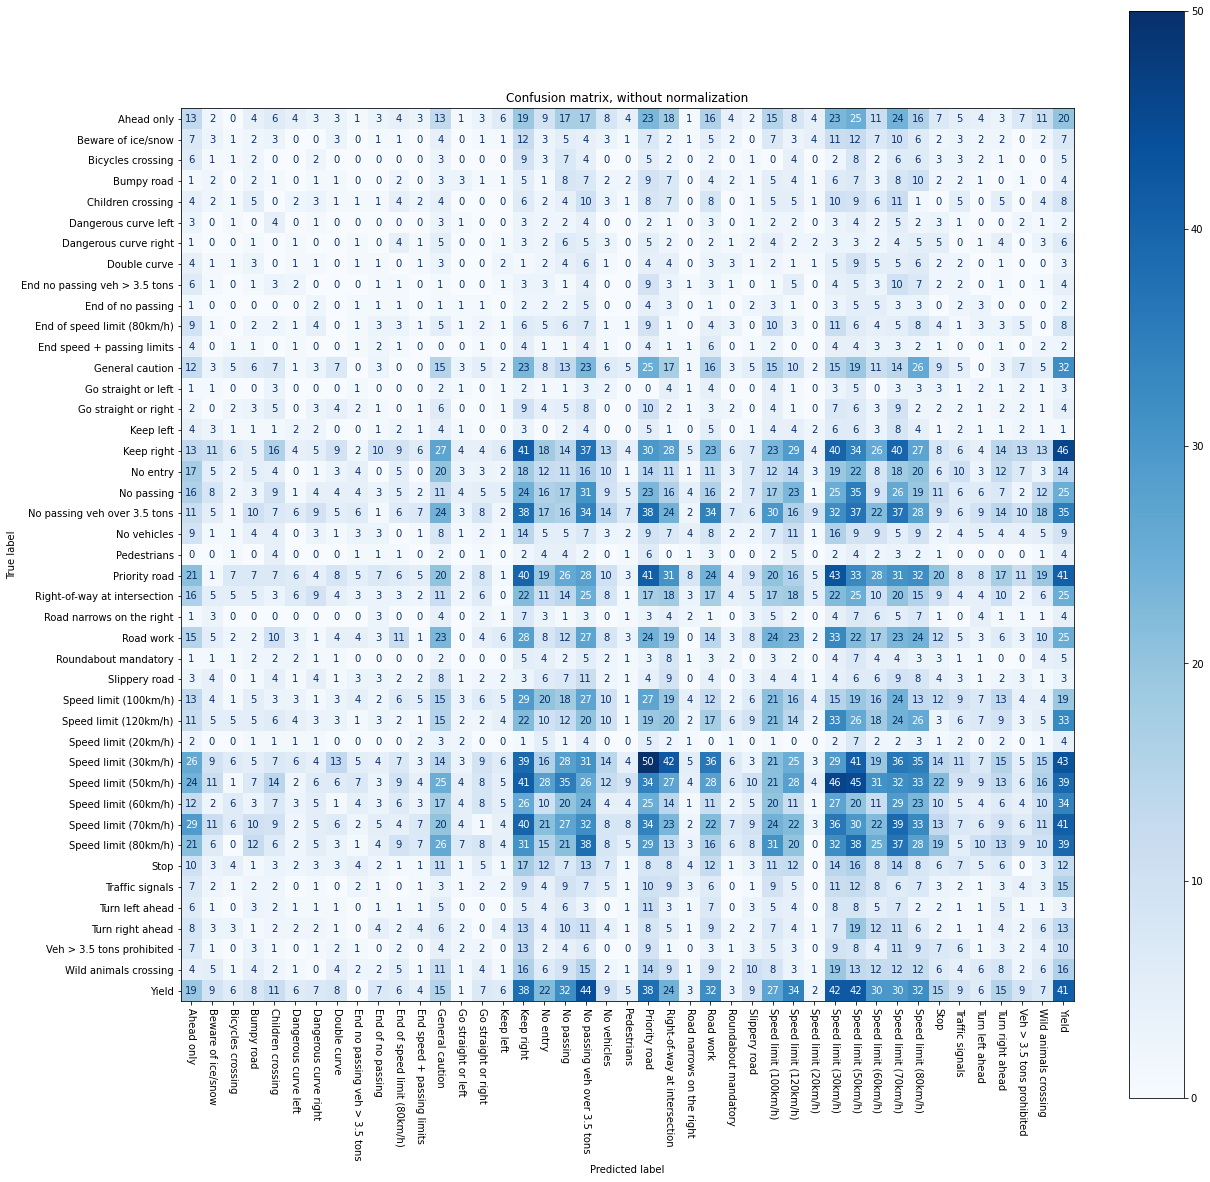

In [ ]:
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(y_test, predDummy2_test)
#print("Confusion matrix:\n{}".format(confusion_matrix(y_test, predDummy2_test)))


titles_options = [("Confusion matrix, without normalization", None)
                  ]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dummy_clf2, X_test_shaped, y_test,
                                 cmap=plt.cm.Blues,
                                 values_format='d'
                                 )
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches(20,20)
    plt.xticks(rotation=270)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

##### 4.2 Logistic Regression Model

In [ ]:
start_time = time.time()

clf_lr = LogisticRegression(solver='saga', max_iter=500)

clf_lr.fit(X_train_shaped, y_train)
preds_rf_val = clf_lr.predict(X_val_shaped)
preds_rf_test = clf_lr.predict(X_test_shaped)

print('Execution time: {:.2f} sec\n'.format(time.time()-start_time))
print("Validation accuracy:", accuracy_score(y_val,preds_rf_val))
print("Test accuracy:", accuracy_score(y_test,preds_rf_test))

""" RESULTS
Execution time: 8813.86 sec
Validation accuracy: 0.879622545269064
Test accuracy: 0.7841646872525733
"""

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Execution time: 8813.86 sec

Validation accuracy: 0.879622545269064
Test accuracy: 0.7841646872525733


##### 4.3 Multi-layer Perceptron

In [ ]:
#DO NOT RUN THIS AGAIN AS IT WILL TAKE 1.5 HRS TO COMPLETE
"""
best_score = 0

for H1 in tqdm(range(10,200,50)):
    for H2 in tqdm(range(10,200,50)):
        mlp = MLPClassifier(hidden_layer_sizes=(H1,H2), random_state=0,activation= 'relu', solver='sgd', early_stopping=True,)
        mlp.fit(X_train_shaped, y_train)
        # evaluate on the validation set
        score = mlp.score(X_val_shaped, y_val)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'hidden_layer_sizes':(H1,H2,H3), 'random_state':0}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
mlp = MLPClassifier(**best_parameters)
mlp.fit(X_train_shaped, y_train)
test_score = mlp.score(X_test_shaped, y_test)
print("Best score on validation set: {:.3f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.3f}".format(test_score))
"""

"""
From first run:
Best score on validation set: 0.929
Best parameters:  {'hidden_layer_sizes': (110, 160), 'random_state': 0}
Test set score with best parameters: 0.773

Time used: 1h 30m
"""

In [ ]:
"""
predictions = mlp.predict(X_test_shaped)
print(classification_report(y_test,predictions))
"""

'\npredictions = mlp.predict(X_test_shaped)\nprint(classification_report(y_test,predictions))\n'

Model tuning


In [ ]:
#Set start time to monitor execution time
start_time = time.time()

mlp_gs = MLPClassifier(hidden_layer_sizes=(110,160), max_iter = 900, early_stopping=True) #Defining new MLP with 2000 iterations or epochs.

params = {'learning_rate': ['constant', 'invscaling']
          'momentum': [0.4, 0.6, 0.9] 
          ,'activation': ['tanh','relu'] 
          'alpha': [0.00001, 0.0001, 0.001]
          ,'solver': ['lbfgs','sgd','adam']
          ,'hidden_layer_sizes': [(110,160), (110,160,180)]
          }
clf_mlp = GridSearchCV(mlp_gs, param_grid = params, cv =3) #Three folded stratefied cross-validation. Njobs define to full CPU usage
clf_mlp.fit(X_train_shaped, y_train)
print('Execution time: {:.2f} sec\n'.format(time.time()-start_time))

print('Best parameters identified as:\n',clf._mlpbest_params_)

means = clf_mlp.cv_results_['mean_test_score']
stds = clf_mlp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_mlp.cv_results_['params']):
    print("\n{:.3f} (+/-{:.3f}) for %r" % (mean, std * 2, params))


In [ ]:
start_time = time.time()

mlp_opt = MLPClassifier(hidden_layer_sizes=(110,160), activation= 'relu', solver='sgd', momentum = 0.6, early_stopping=True, learning_rate = 'constant', alpha = 1e-05, max_iter = 900)
mlp_opt.fit(X_train_shaped,y_train)
val_score = mlp_opt.score(X_val_shaped, y_val)
test_score = mlp_opt.score(X_test_shaped, y_test)

print('Execution time: {:.2f} sec\n'.format(time.time()-start_time))
print("Validation score: {:.2f}".format(val_score*100))
print("Test score: {:.2f}".format(test_score*100))

Execution time: 458.13 sec

Validation score: 87.80
Test score: 79.95


Text(0.5, 1.0, 'Loss curve')

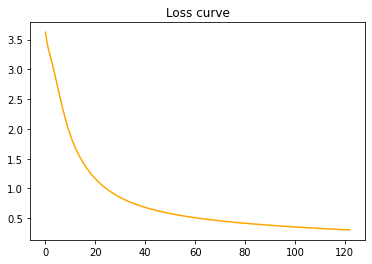

In [ ]:
#Plotting traning and validation loss curves for best parameters
plt.plot(mlp_opt.loss_curve_, color = 'orange')
plt.title('Loss curve')


Text(0.5, 1.0, 'Validation curve')

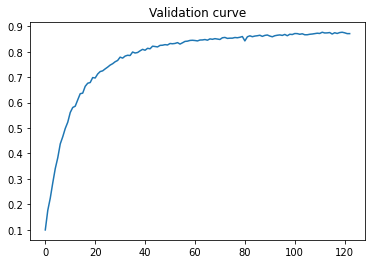

In [ ]:
plt.plot(mlp_opt.validation_scores_)
plt.title('Validation curve')

In [ ]:
mlp_preds = mlp_opt.predict(X_test_shaped)
print(classification_report(y_test,mlp_preds))

              precision    recall  f1-score   support

           0       0.92      0.20      0.33        60
           1       0.78      0.82      0.80       720
           2       0.69      0.91      0.79       750
           3       0.73      0.67      0.70       450
           4       0.78      0.81      0.80       660
           5       0.64      0.66      0.65       630
           6       0.89      0.72      0.79       150
           7       0.73      0.66      0.69       450
           8       0.68      0.77      0.72       450
           9       0.92      0.98      0.95       480
          10       0.91      0.87      0.89       660
          11       0.72      0.75      0.73       420
          12       0.83      0.80      0.81       690
          13       0.93      0.95      0.94       720
          14       0.98      0.94      0.96       270
          15       0.82      0.90      0.86       210
          16       0.96      0.94      0.95       150
          17       0.98    

#### 5.0 Evaluation

##### 5.1 Receiver Operating Characteristics curve (ROC)

###### 5.1.1 Logistic Regression

In [ ]:
#Logistic Regression ROC:

y_pred_proba = model.predict_proba(X_test) [:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

###### 5.1.2 Neural Network

In [ ]:
#Performing one hot encoding
encoder = LabelEncoder()

encoder.fit(y)
y = encoder.transform(y)
y = np_utils.to_categorical(y)

encoder.fit(y_test)
y_test = encoder.transform(y_test)
y_test = np_utils.to_categorical(y_test)

In [ ]:
#Neural Network ROC:  Classes in isolation
y_score = mlp_opt.predict_proba(X_test_shaped)

n_classes = 43

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


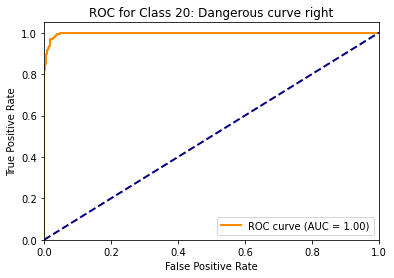

In [ ]:
#Plotting ROC curve for Class 20: Dangerous curve right

plt.figure()
lw = 2 # line_width
plt.plot(fpr[20], tpr[20], color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc[20]) # Drawing Curve according to 2. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Class 20: Dangerous curve right')
plt.legend(loc="lower right")
plt.show()

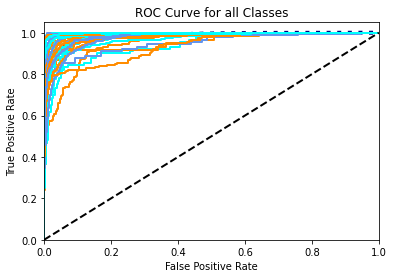

In [ ]:
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Classes')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


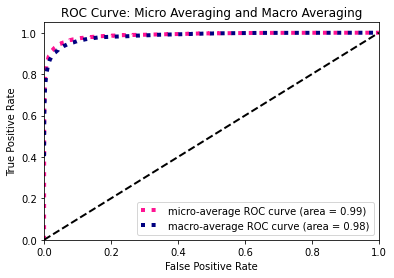

In [ ]:
# Process of plotting roc-auc curve belonging to all classes.

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Micro Averaging and Macro Averaging')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_score
y_test

##### 5.2 Synthetic Majority Oversampling / Undersampling Technique (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=11)

os_X, os_y = over_sampling.fit_resample(X_train_shaped, y_train)

(array([ 168., 1776., 1800., 1128., 1584., 1488.,  336., 1152., 1128.,
        1176., 1608., 1056., 1680., 1728.,  624.,  504.,  336.,  888.,
         960.,  168.,  288.,  264.,  312.,  408.,  216., 1200.,  480.,
         192.,  432.,  216.,  360.,  624.,  192.,  551.,  336.,  960.,
         312.,  168., 1656.,  240.,  288.,  192.,  192.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of

(array([1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800.,
        1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800.,
        1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800.,
        1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800.,
        1800., 1800., 1800., 1800., 1800., 1800., 1800.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of

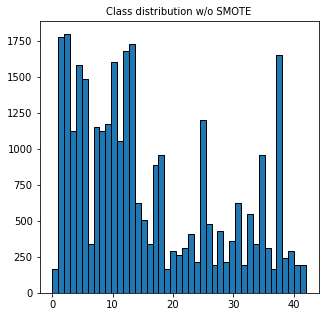

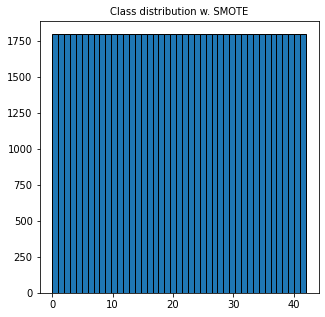

In [ ]:
#Then we can evaluate how the SMOTE function has adjusted the distribution of classes

plt.figure(figsize=(5,5))
plt.title('Class distribution w/o SMOTE',fontsize=10)
display(plt.hist(y_train,bins=43, histtype='bar', ec='black'))

plt.figure(figsize=(5,5))
plt.title('Class distribution w. SMOTE',fontsize=10)
display(plt.hist(os_y,bins=43, histtype='bar', ec='black'))

In [ ]:
mlp_opt.fit(os_X,os_y)

In [ ]:
val_score = mlp_opt.score(X_val_shaped, y_val)
test_score = mlp_opt.score(X_test_shaped, y_test)

print('Execution time: {:.2f} sec\n'.format(time.time()-start_time))
print("Validation score: {:.3f}".format(val_score))
print("Test score: {:.3f}".format(test_score))


Execution time: 7080.16 sec

Validation score: 0.896
Test score: 0.804


In [ ]:
mlp_preds = mlp_opt.predict(X_test_shaped)
print(classification_report(y_test,mlp_preds))

              precision    recall  f1-score   support

           0       0.70      0.50      0.58        60
           1       0.80      0.83      0.81       720
           2       0.75      0.89      0.81       750
           3       0.68      0.68      0.68       450
           4       0.81      0.85      0.83       660
           5       0.65      0.69      0.67       630
           6       0.93      0.73      0.82       150
           7       0.73      0.63      0.68       450
           8       0.65      0.78      0.71       450
           9       0.94      0.96      0.95       480
          10       0.90      0.89      0.90       660
          11       0.73      0.72      0.73       420
          12       0.85      0.81      0.83       690
          13       0.96      0.94      0.95       720
          14       0.97      0.94      0.95       270
          15       0.81      0.87      0.84       210
          16       0.96      0.95      0.96       150
          17       0.95    

##### 5.3 Confusion Matrices


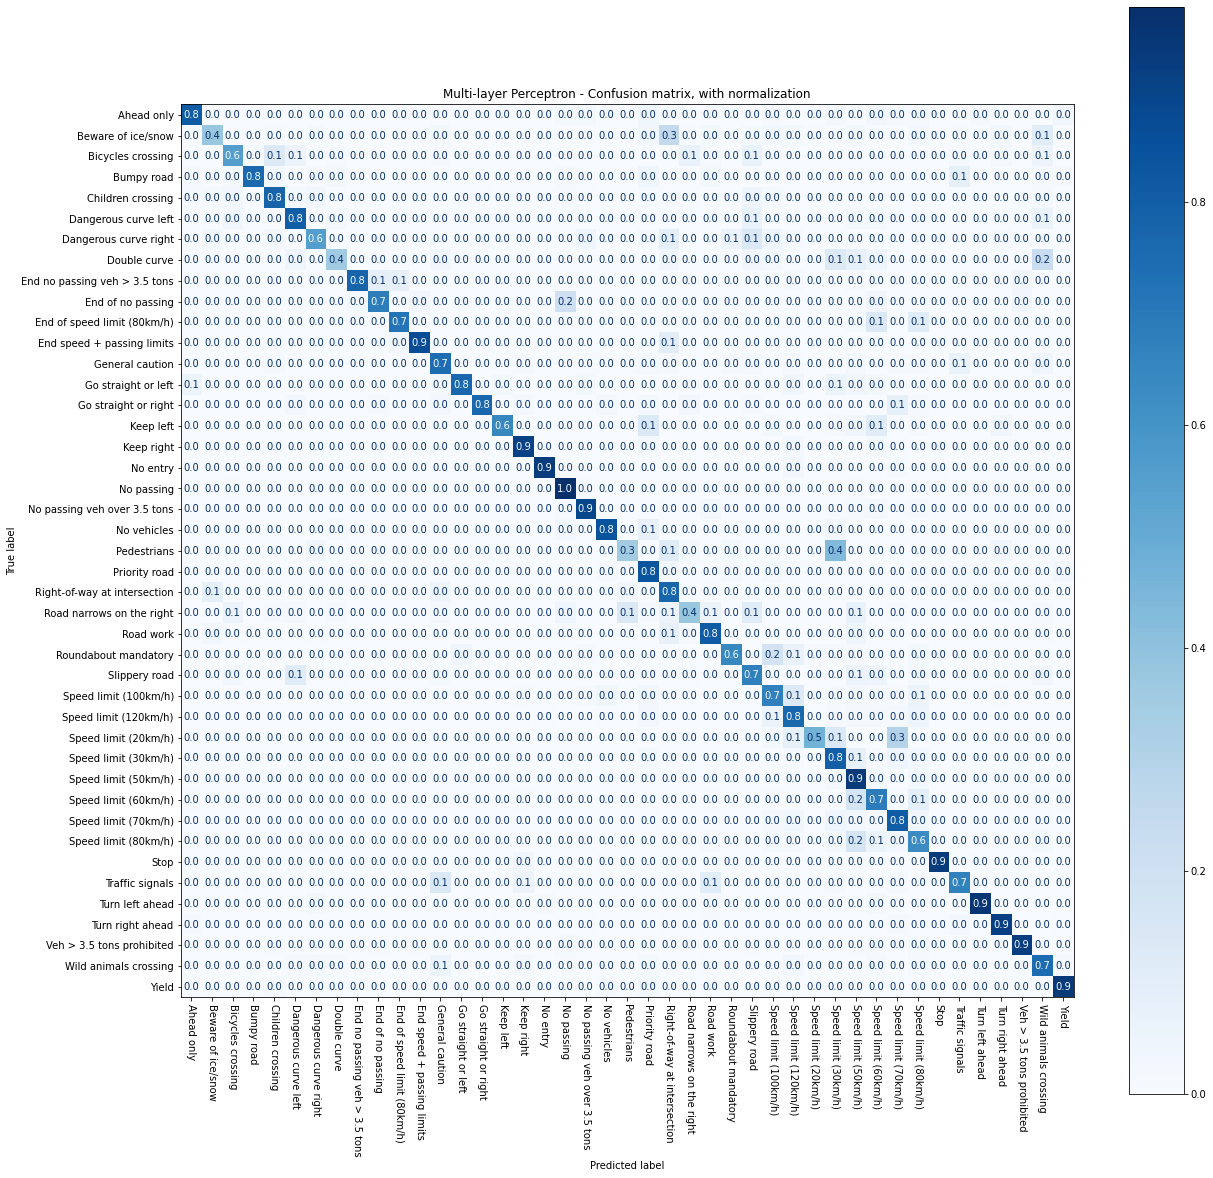

In [ ]:
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(y_test, preds_rf_test)
#print("Confusion matrix:\n{}".format(confusion_matrix(y_test, predDummy2_test)))


titles_options = [("Multi-layer Perceptron - Confusion matrix, with normalization", None)
                  ]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(mlp_opt, X_test_shaped, y_test,
                                 cmap=plt.cm.Blues,                               
                                 normalize='true', values_format ='.1f',

                                 )
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches(20,20)
    plt.xticks(rotation=270)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

Logistic Regression Model

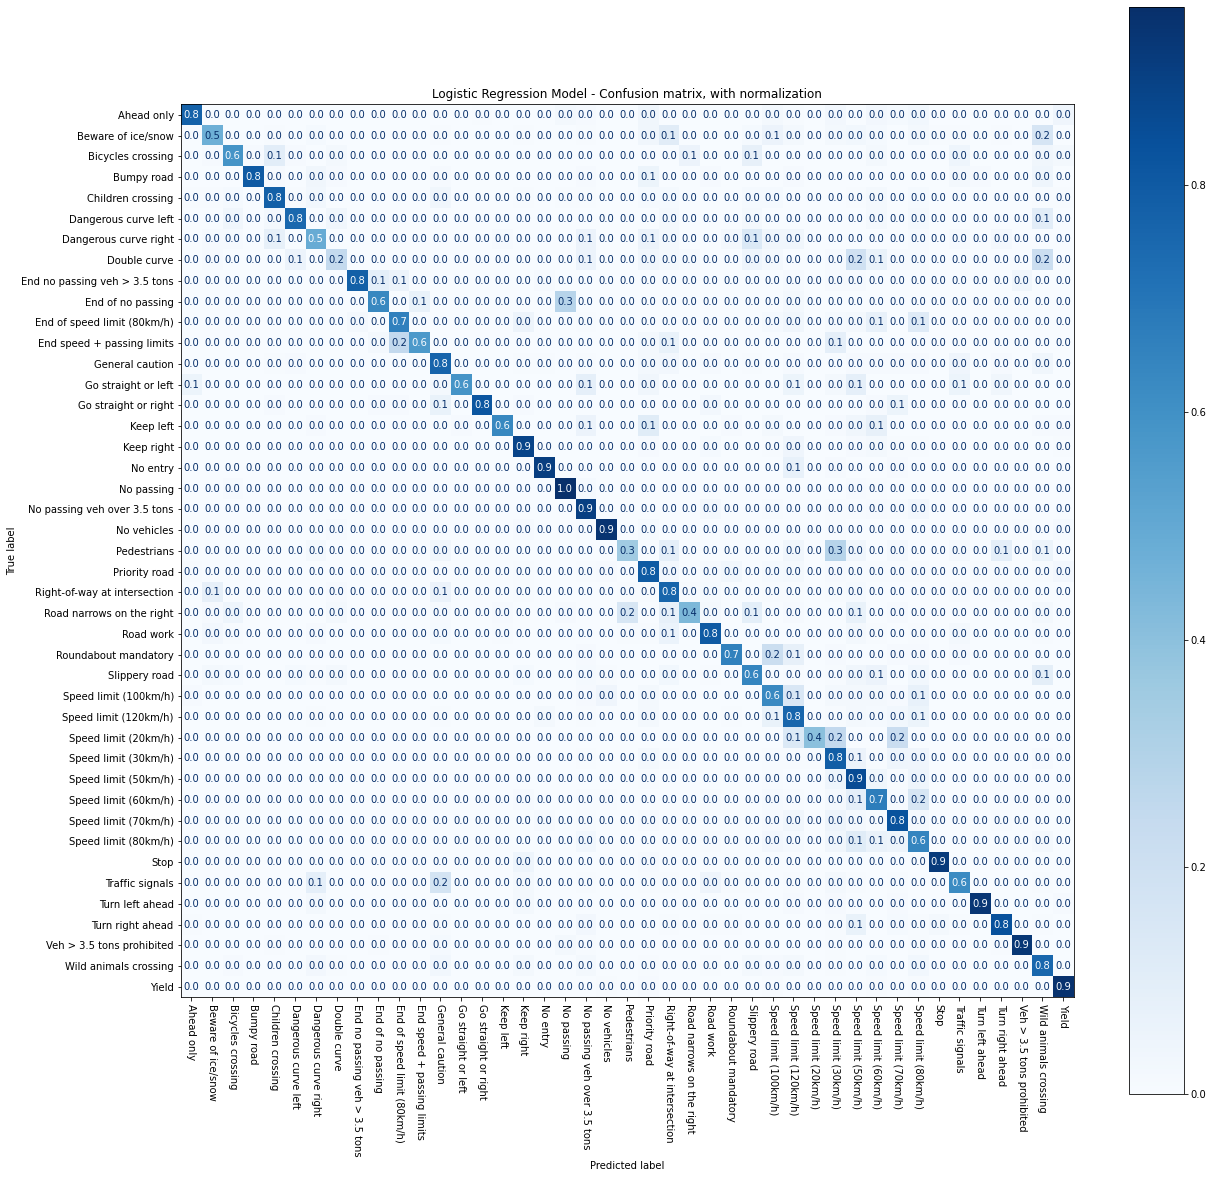

In [ ]:
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(y_test, preds_rf_test)
#print("Confusion matrix:\n{}".format(confusion_matrix(y_test, predDummy2_test)))


titles_options = [("Logistic Regression Model - Confusion matrix, with normalization", None)
                  ]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_lr, X_test_shaped, y_test,
                                 cmap=plt.cm.Blues,                               
                                 normalize='true', values_format ='.1f',

                                 )
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches(20,20)
    plt.xticks(rotation=270)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()